## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/leeds_msc_ocom5300m_project/results/"

Mounted at /content/drive


Importing required libraries

In [4]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [6]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/leeds_msc_ocom5300m_project/results/


In [7]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=1
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:01<00:00, 105637183.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter1_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/15 06:28:21 AM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6000, Top 1 Acc=6.25, Top 5 Acc=48.44
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6000, Top 1 Acc=6.25, Top 5 Acc=48.44
02/15 06:28:29 AM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4600, Top 1 Acc=31.61, Top 5 Acc=78.94
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4600, Top 1 Acc=31.61, Top 5 Acc=78.94
02/15 06:28:36 AM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4331, Top 1 Acc=36.79, Top 5 Acc=82.30
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4331, Top 1 Acc=36.79, Top 5 Acc=82.30
02/15 06:28:43 AM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4157, Top 1 Acc=39.77, Top 5 Acc=84.42


CPU times: user 21min 48s, sys: 1min 21s, total: 23min 9s
Wall time: 23min 20s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter1_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter1_capsnet_cifar10_model.pt')

best_multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter1_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter1_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter1_capsnet_cifar10_model.name = 'best_multilayer_inter1_capsnet_cifar10_model'
best_multilayer_inter1_capsnet_cifar10_model = best_multilayer_inter1_capsnet_cifar10_model.to(device)
best_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter1_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter1_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 07:57:01 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.312
02/19 07:57:01 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=96.094
02/19 07:57:01 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.083, Top 5 Acc=94.792
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.083, Top 5 Acc=94.792
02/19 07:57:01 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=94.922
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/157

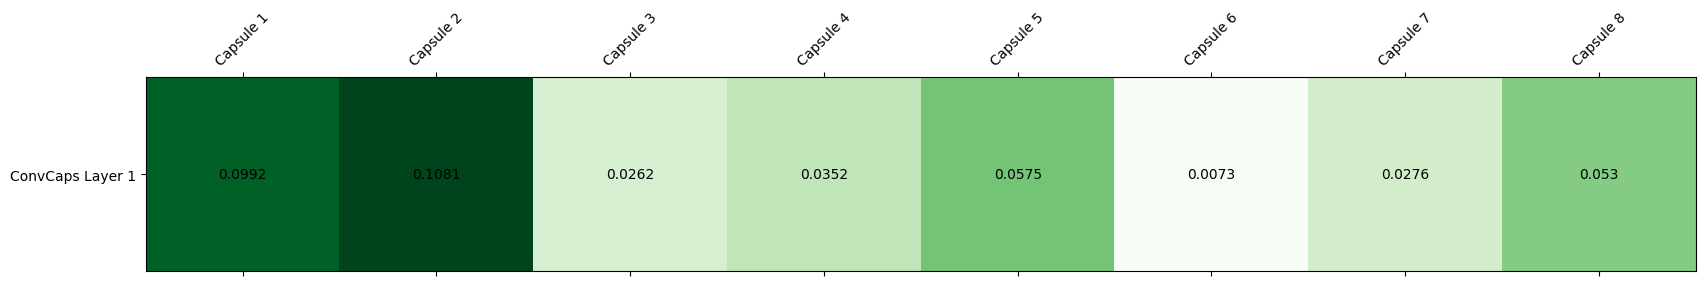

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

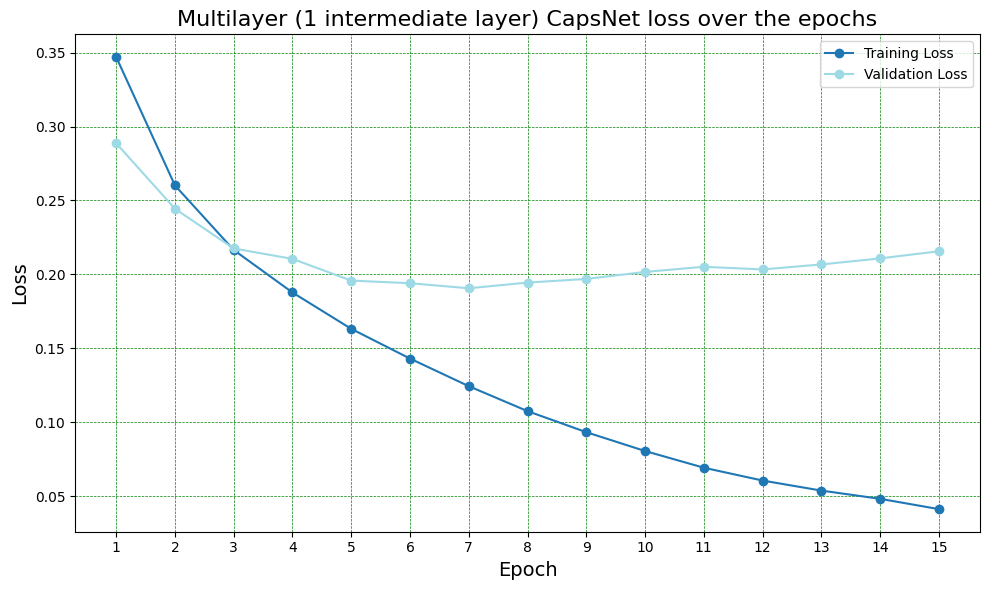

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (1 intermediate layer) CapsNet loss over the epochs')

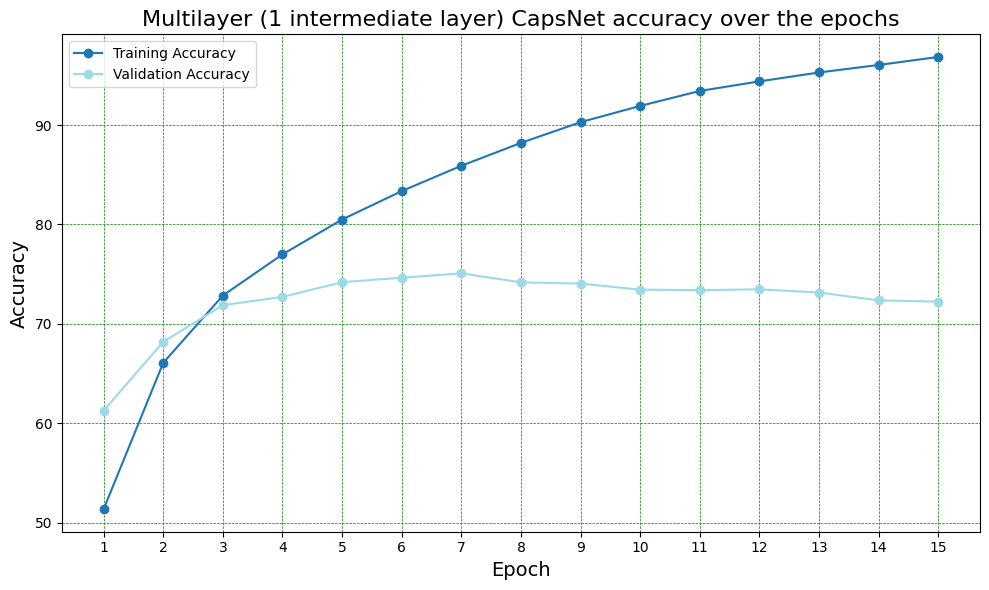

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (1 intermediate layer) CapsNet accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=2
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter2_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/15 05:57:01 AM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6340, Top 1 Acc=10.94, Top 5 Acc=53.12
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6340, Top 1 Acc=10.94, Top 5 Acc=53.12
02/15 05:57:11 AM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4852, Top 1 Acc=28.58, Top 5 Acc=74.93
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4852, Top 1 Acc=28.58, Top 5 Acc=74.93
02/15 05:57:21 AM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4467, Top 1 Acc=34.56, Top 5 Acc=80.27
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4467, Top 1 Acc=34.56, Top 5 Acc=80.27
02/15 05:57:30 AM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4277, Top 1 Acc=37.78, Top 5 Acc=82.5

CPU times: user 29min 13s, sys: 1min 51s, total: 31min 4s
Wall time: 31min 18s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter2_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter2_capsnet_cifar10_model.pt')

best_multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter2_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter2_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter2_capsnet_cifar10_model.name = 'best_multilayer_inter2_capsnet_cifar10_model'
best_multilayer_inter2_capsnet_cifar10_model = best_multilayer_inter2_capsnet_cifar10_model.to(device)
best_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter2_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter2_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 07:58:42 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
02/19 07:58:42 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.656
02/19 07:58:42 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=74.479, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=74.479, Top 5 Acc=97.917
02/19 07:58:42 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=72.656, Top 5 Acc=97.266
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/157

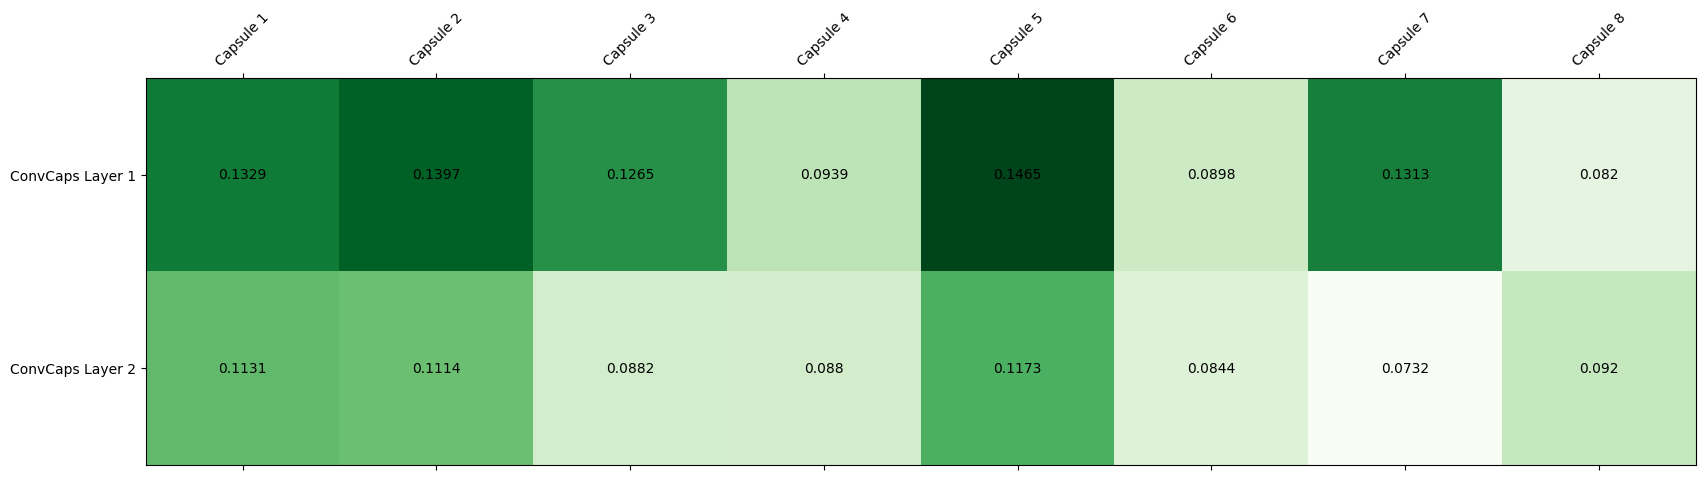

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter2_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

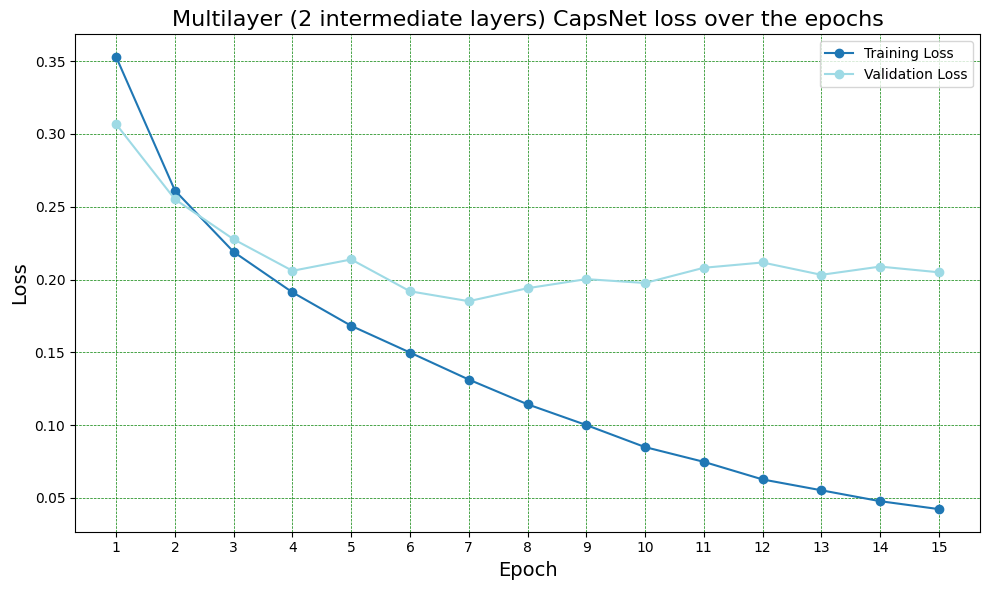

In [ ]:
utils.plot_line_chart(epoch_loss[:, :15], ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (2 intermediate layers) CapsNet loss over the epochs')

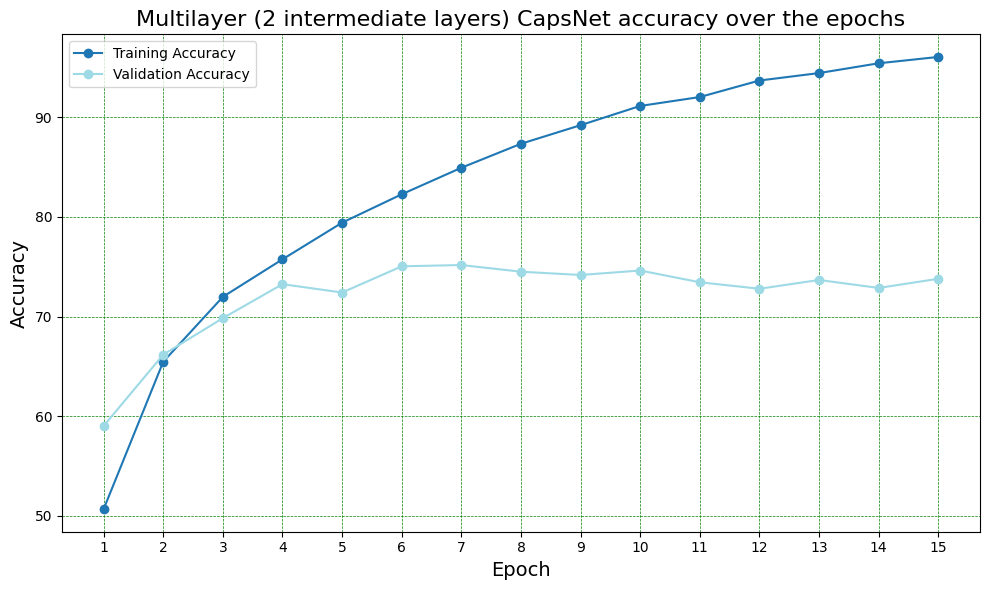

In [ ]:
utils.plot_line_chart(epoch_accuracy[:, :15], ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (2 intermediate layers) CapsNet accuracy over the epochs')

## 3 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=3
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): Caps

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter3_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/15 05:17:27 AM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7412, Top 1 Acc=12.50, Top 5 Acc=40.62
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7412, Top 1 Acc=12.50, Top 5 Acc=40.62
02/15 05:17:40 AM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4943, Top 1 Acc=26.08, Top 5 Acc=72.40
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4943, Top 1 Acc=26.08, Top 5 Acc=72.40
02/15 05:17:52 AM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4558, Top 1 Acc=32.30, Top 5 Acc=79.05
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4558, Top 1 Acc=32.30, Top 5 Acc=79.05
02/15 05:18:05 AM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4341, Top 1 Acc=35.99, Top 5 Acc=81.8

CPU times: user 36min 55s, sys: 2min 20s, total: 39min 16s
Wall time: 39min 30s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter3_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter3_capsnet_cifar10_model.pt')

best_multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter3_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter3_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter3_capsnet_cifar10_model.name = 'best_multilayer_inter3_capsnet_cifar10_model'
best_multilayer_inter3_capsnet_cifar10_model = best_multilayer_inter3_capsnet_cifar10_model.to(device)
best_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): Caps

In [ ]:
capsnet_inter3_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter3_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:00:22 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=96.875
02/19 08:00:22 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=97.656
02/19 08:00:22 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=97.917
02/19 08:00:22 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.953, Top 5 Acc=98.047
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/157

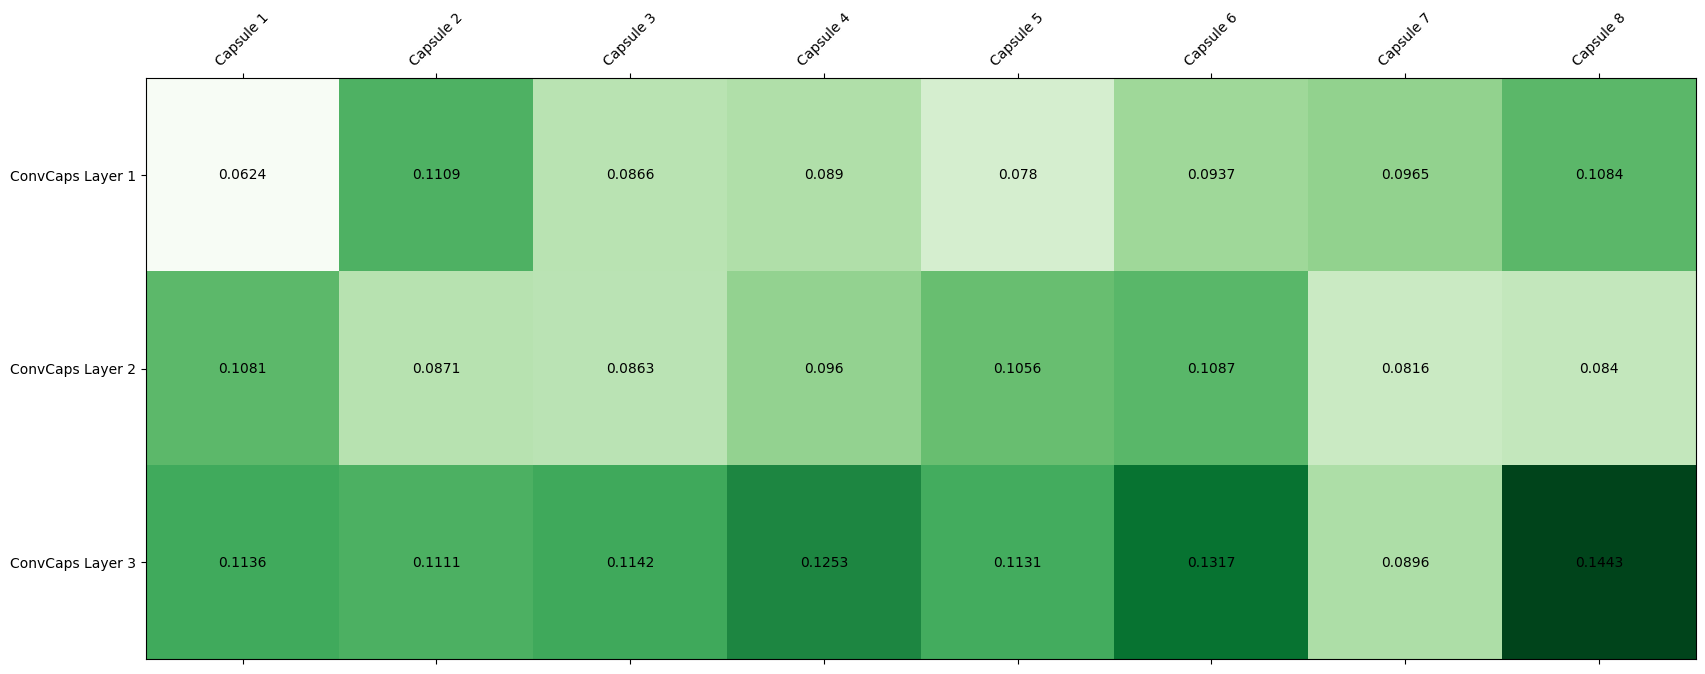

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter3_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

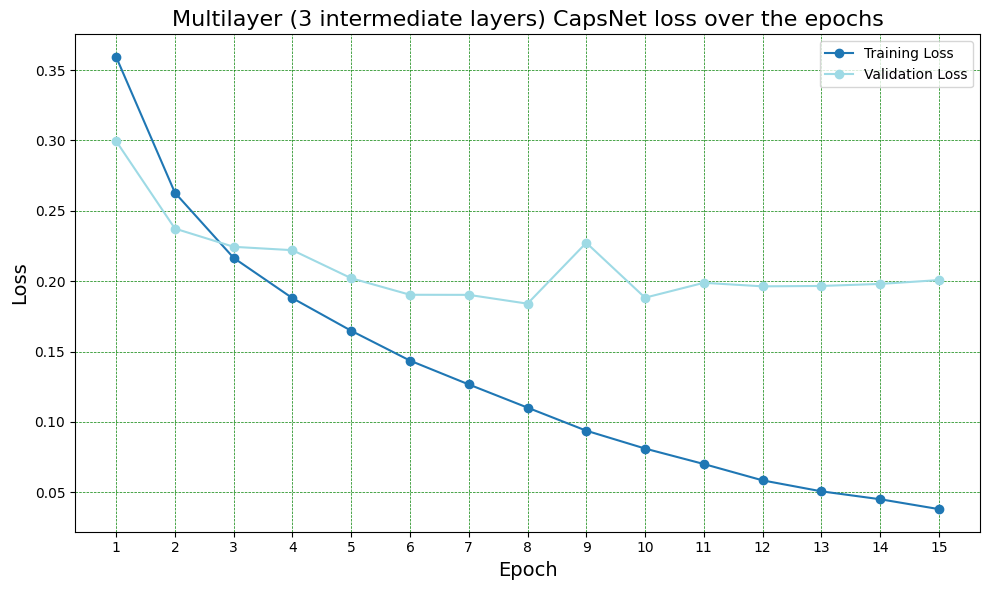

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (3 intermediate layers) CapsNet loss over the epochs')

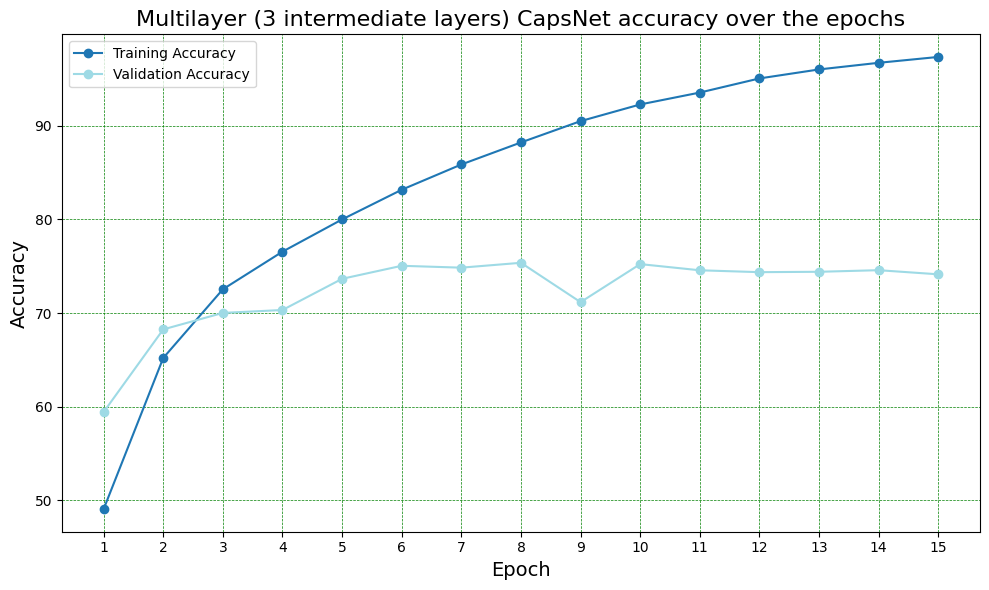

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (3 intermediate layers) CapsNet accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=4
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter4_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/15 04:30:34 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7926, Top 1 Acc=4.69, Top 5 Acc=43.75
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7926, Top 1 Acc=4.69, Top 5 Acc=43.75
02/15 04:30:49 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4997, Top 1 Acc=27.00, Top 5 Acc=72.79
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4997, Top 1 Acc=27.00, Top 5 Acc=72.79
02/15 04:31:04 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4625, Top 1 Acc=32.81, Top 5 Acc=77.52
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4625, Top 1 Acc=32.81, Top 5 Acc=77.52
02/15 04:31:20 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4412, Top 1 Acc=35.65, Top 5 Acc=80.59


CPU times: user 43min 43s, sys: 2min 51s, total: 46min 34s
Wall time: 46min 50s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter4_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter4_capsnet_cifar10_model.pt')

best_multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter4_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter4_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter4_capsnet_cifar10_model.name = 'best_multilayer_inter4_capsnet_cifar10_model'
best_multilayer_inter4_capsnet_cifar10_model = best_multilayer_inter4_capsnet_cifar10_model.to(device)
best_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter4_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter4_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:01:33 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=92.188
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=92.188
02/19 08:01:33 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=92.969
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=92.969
02/19 08:01:33 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=91.667
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=91.667
02/19 08:01:34 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=72.266, Top 5 Acc=93.359
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/157

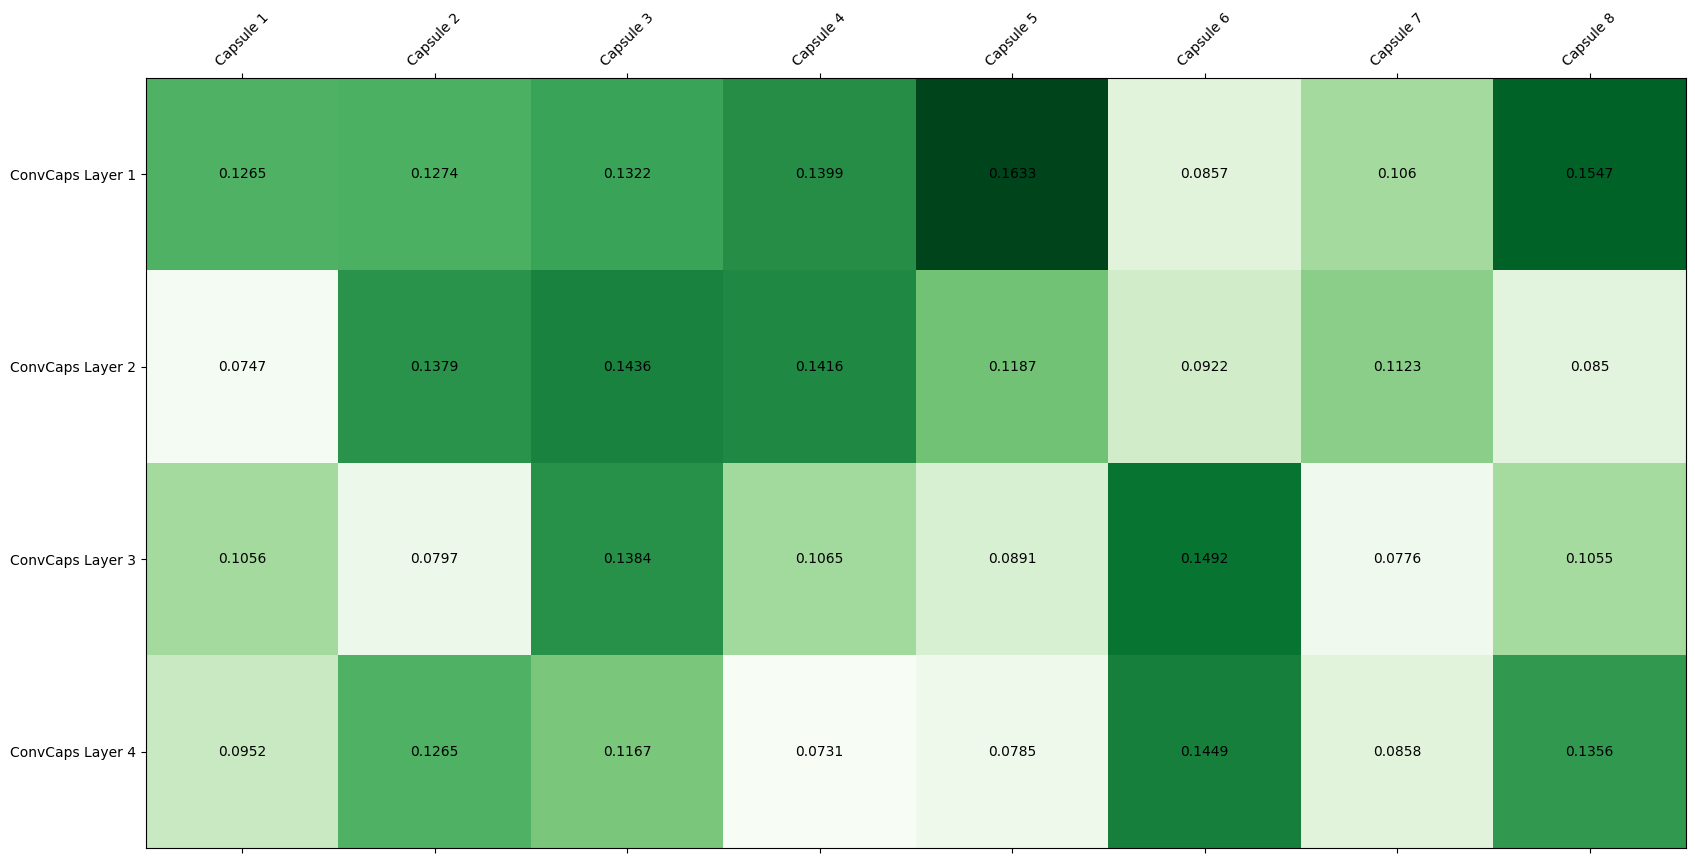

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter4_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

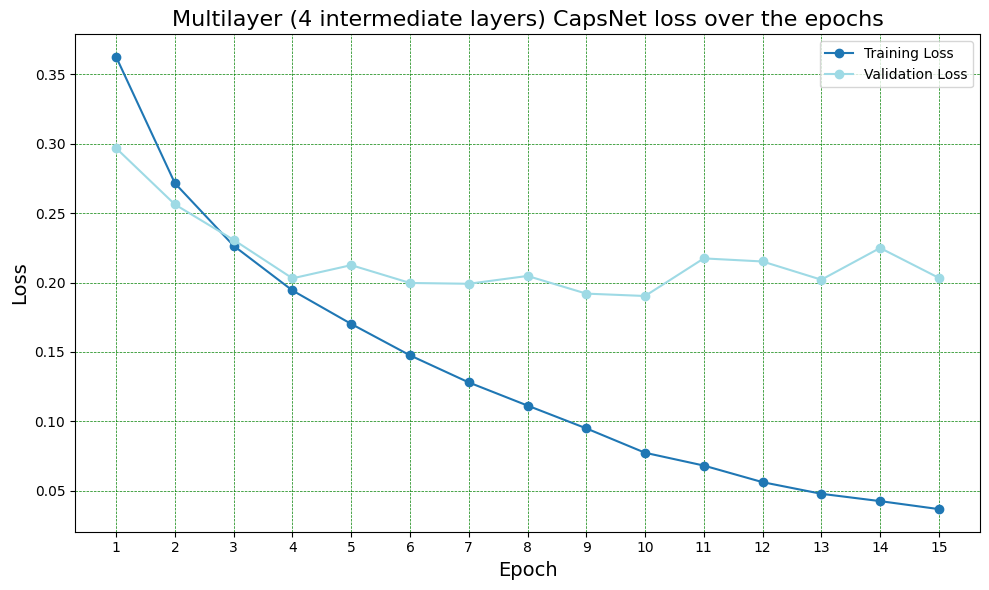

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (4 intermediate layers) CapsNet loss over the epochs')

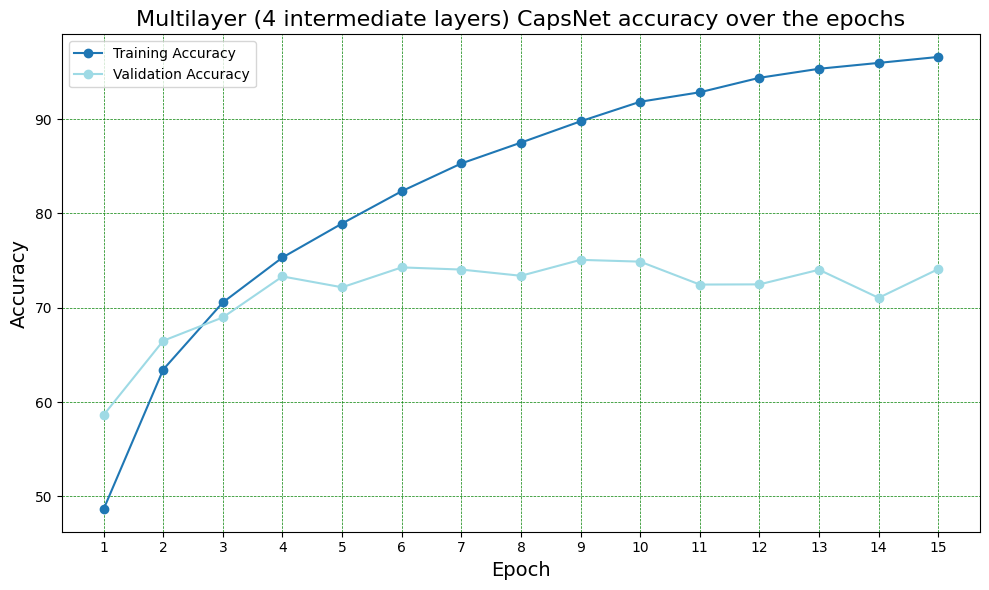

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (4 intermediate layers) CapsNet accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=5
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter5_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/15 03:35:16 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8129, Top 1 Acc=9.38, Top 5 Acc=48.44
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8129, Top 1 Acc=9.38, Top 5 Acc=48.44
02/15 03:35:33 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5073, Top 1 Acc=24.93, Top 5 Acc=71.30
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5073, Top 1 Acc=24.93, Top 5 Acc=71.30
02/15 03:35:50 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4616, Top 1 Acc=32.00, Top 5 Acc=78.05
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4616, Top 1 Acc=32.00, Top 5 Acc=78.05
02/15 03:36:08 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4375, Top 1 Acc=36.06, Top 5 Acc=81.28


CPU times: user 51min 32s, sys: 3min 24s, total: 54min 56s
Wall time: 55min 18s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter5_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter5_capsnet_cifar10_model.pt')

best_multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter5_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter5_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter5_capsnet_cifar10_model.name = 'best_multilayer_inter5_capsnet_cifar10_model'
best_multilayer_inter5_capsnet_cifar10_model = best_multilayer_inter5_capsnet_cifar10_model.to(device)
best_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter5_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter5_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:02:53 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:02:53 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=98.438
02/19 08:02:53 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=97.396
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=97.396
02/19 08:02:54 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=78.516, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/157

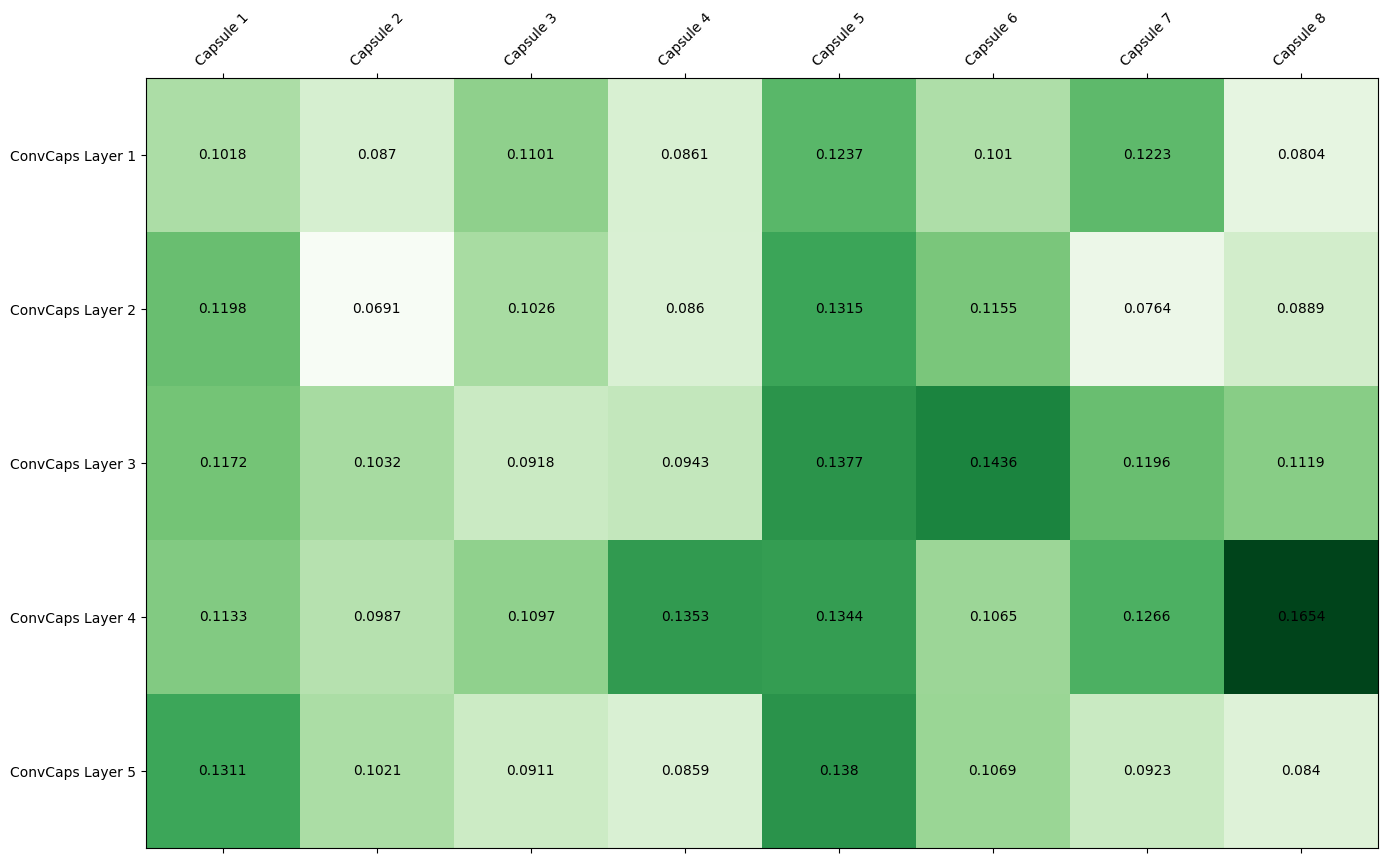

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter5_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

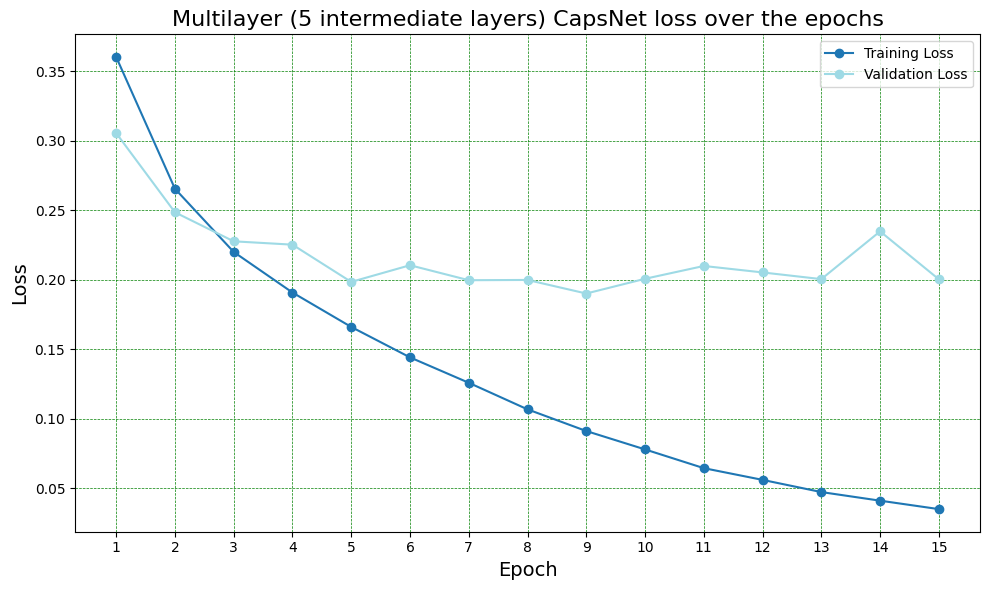

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (5 intermediate layers) CapsNet loss over the epochs')

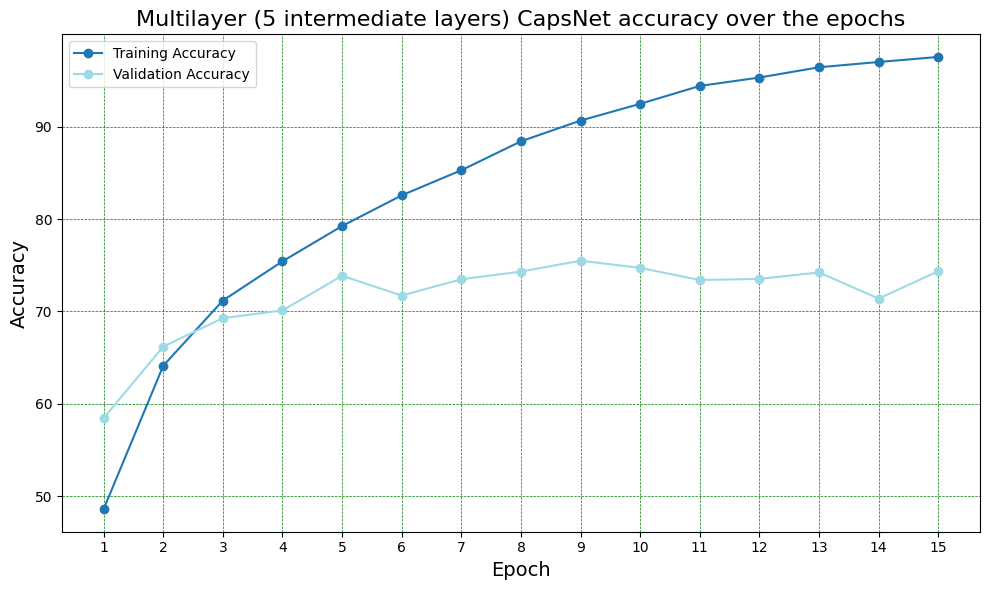

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (5 intermediate layers) CapsNet accuracy over the epochs')

## 6 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=6
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 11:23:12 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8111, Top 1 Acc=9.38, Top 5 Acc=51.56
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8111, Top 1 Acc=9.38, Top 5 Acc=51.56
02/14 11:23:33 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5116, Top 1 Acc=24.47, Top 5 Acc=70.72
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5116, Top 1 Acc=24.47, Top 5 Acc=70.72
02/14 11:23:54 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4678, Top 1 Acc=30.91, Top 5 Acc=77.20
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4678, Top 1 Acc=30.91, Top 5 Acc=77.20
02/14 11:24:15 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4471, Top 1 Acc=34.42, Top 5 Acc=79.84


CPU times: user 1h 2min 11s, sys: 3min 58s, total: 1h 6min 10s
Wall time: 1h 6min 33s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter6_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter6_capsnet_cifar10_model.pt')

best_multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter6_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter6_capsnet_cifar10_model.name = 'best_multilayer_inter6_capsnet_cifar10_model'
best_multilayer_inter6_capsnet_cifar10_model = best_multilayer_inter6_capsnet_cifar10_model.to(device)
best_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter6_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter6_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:04:03 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:04:03 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=96.875
02/19 08:04:03 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=96.875
02/19 08:04:03 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/157

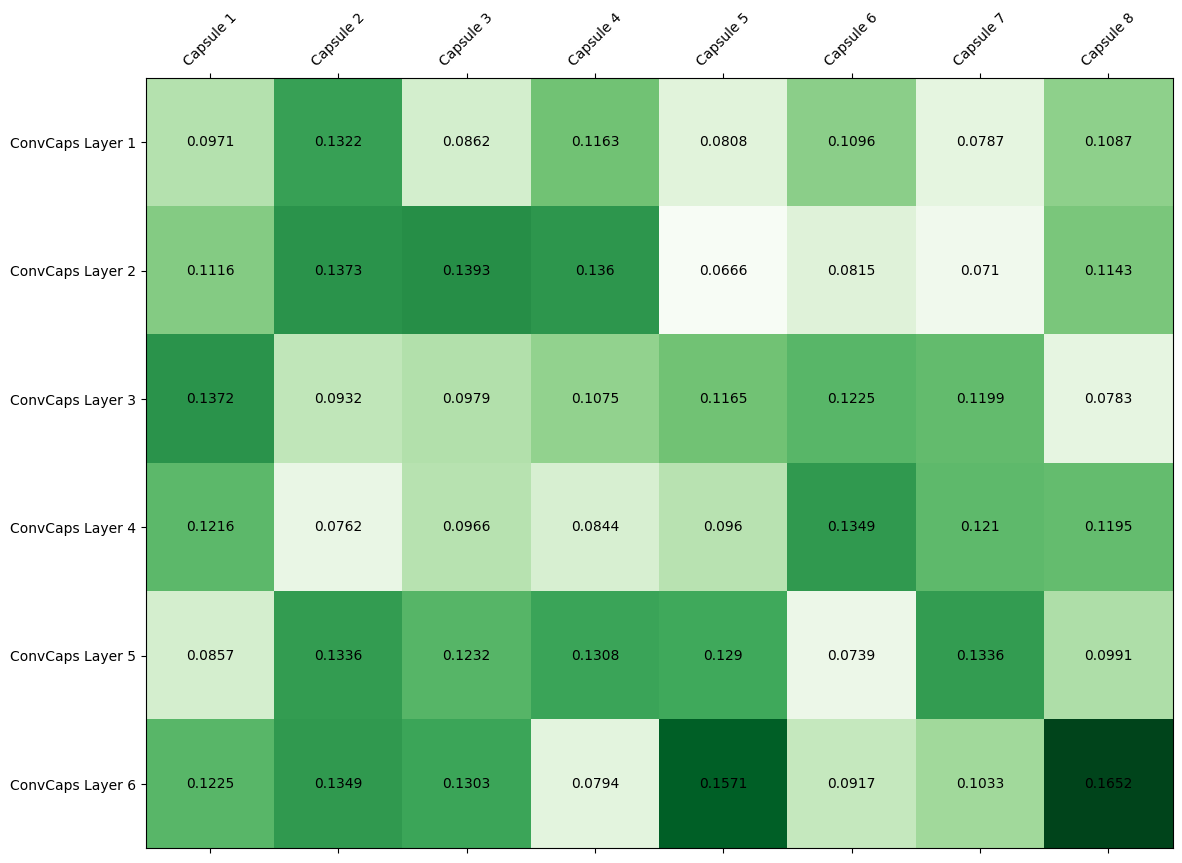

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter6_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

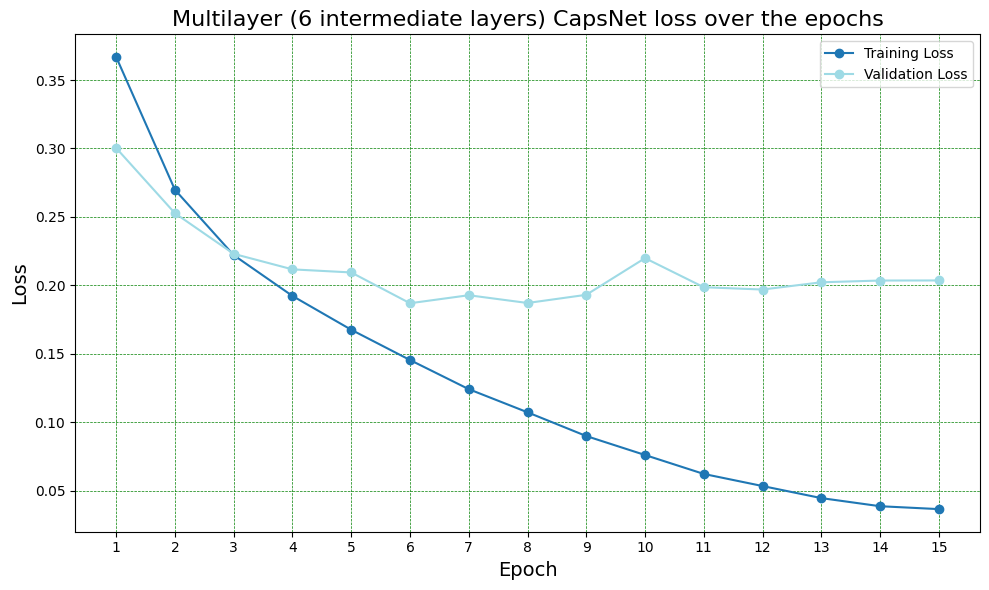

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (6 intermediate layers) CapsNet loss over the epochs')

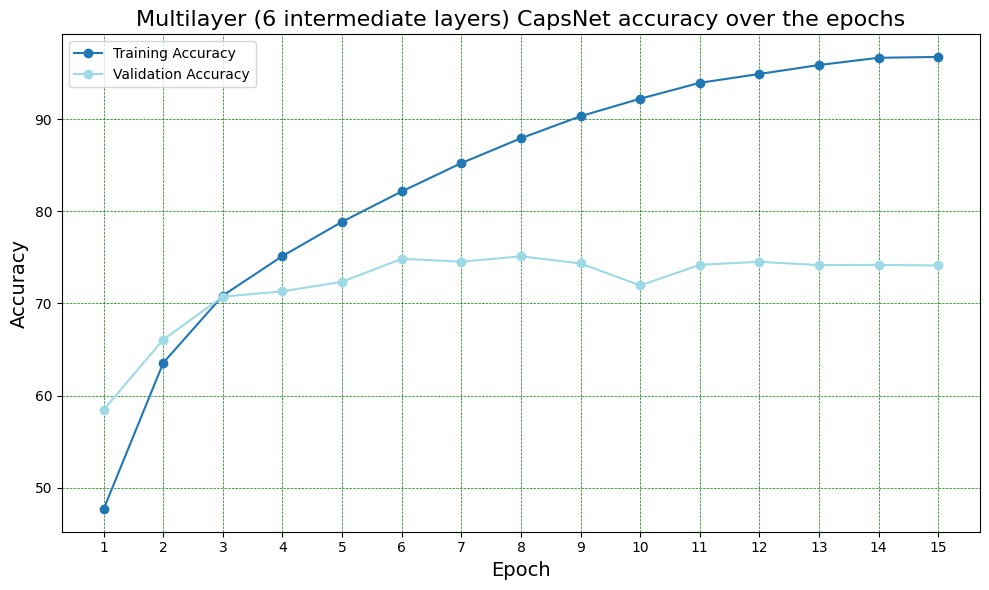

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (6 intermediate layers) CapsNet accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=7
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 10:06:36 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8153, Top 1 Acc=9.38, Top 5 Acc=50.00
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8153, Top 1 Acc=9.38, Top 5 Acc=50.00
02/14 10:07:00 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5192, Top 1 Acc=25.22, Top 5 Acc=69.88
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5192, Top 1 Acc=25.22, Top 5 Acc=69.88
02/14 10:07:24 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4776, Top 1 Acc=30.55, Top 5 Acc=75.74
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4776, Top 1 Acc=30.55, Top 5 Acc=75.74
02/14 10:07:48 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4545, Top 1 Acc=33.82, Top 5 Acc=79.07


CPU times: user 1h 10min 44s, sys: 4min 35s, total: 1h 15min 20s
Wall time: 1h 16min 33s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter7_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter7_capsnet_cifar10_model.pt')

best_multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter7_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter7_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter7_capsnet_cifar10_model.name = 'best_multilayer_inter7_capsnet_cifar10_model'
best_multilayer_inter7_capsnet_cifar10_model = best_multilayer_inter7_capsnet_cifar10_model.to(device)
best_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter7_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter7_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:05:20 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:05:20 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=95.312
02/19 08:05:20 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=94.792
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=94.792
02/19 08:05:20 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=94.141
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/157

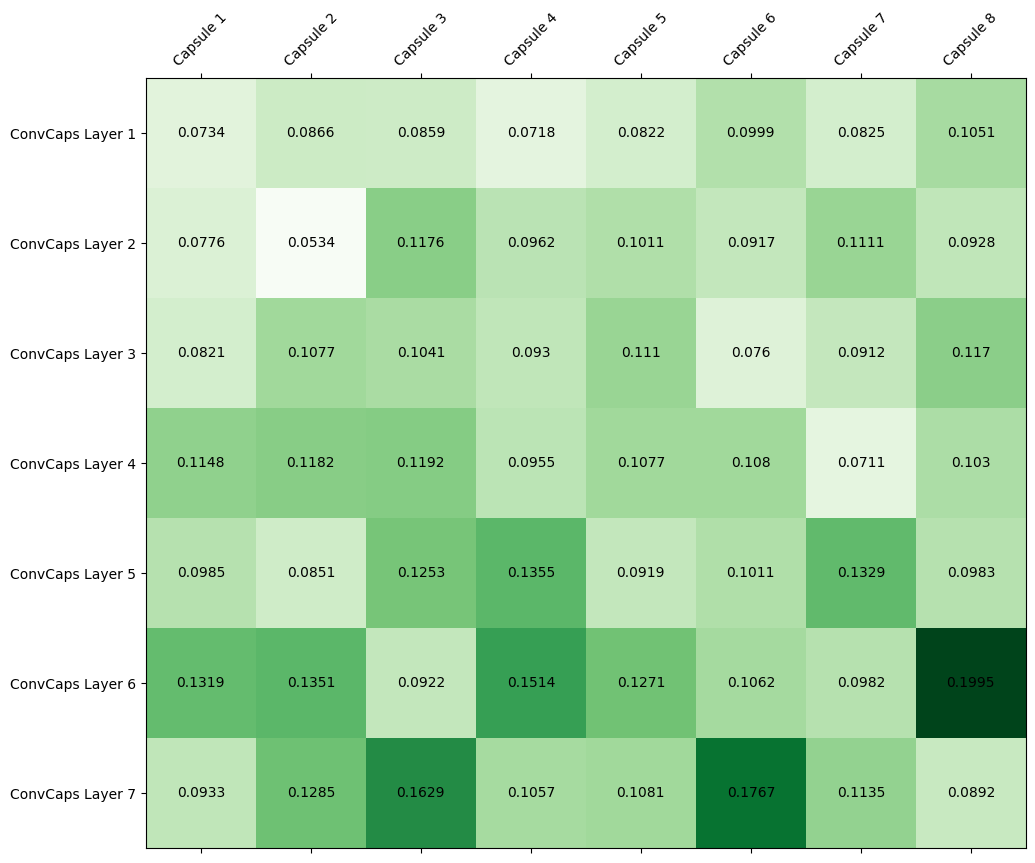

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter7_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

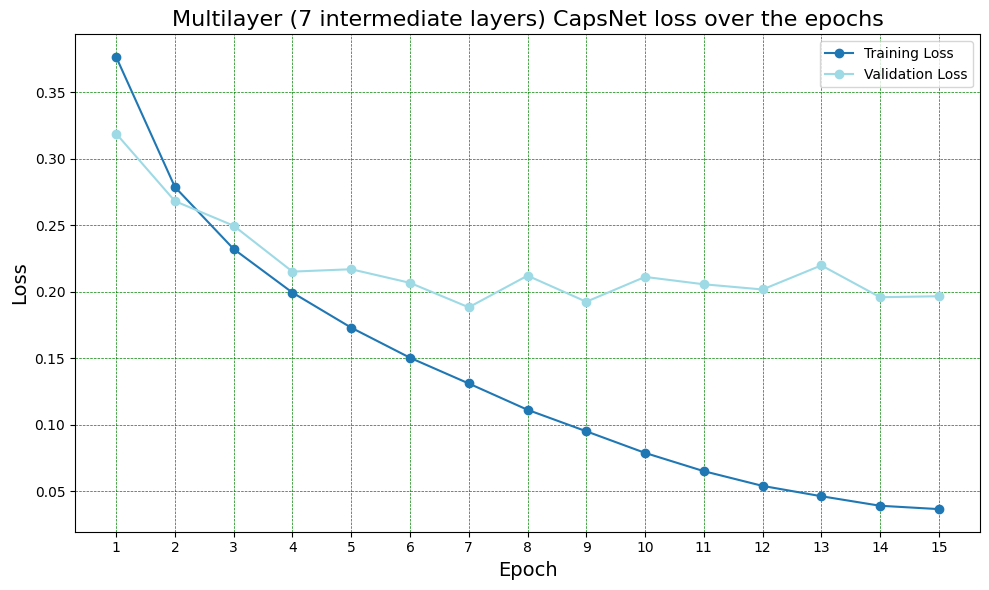

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (7 intermediate layers) CapsNet loss over the epochs')

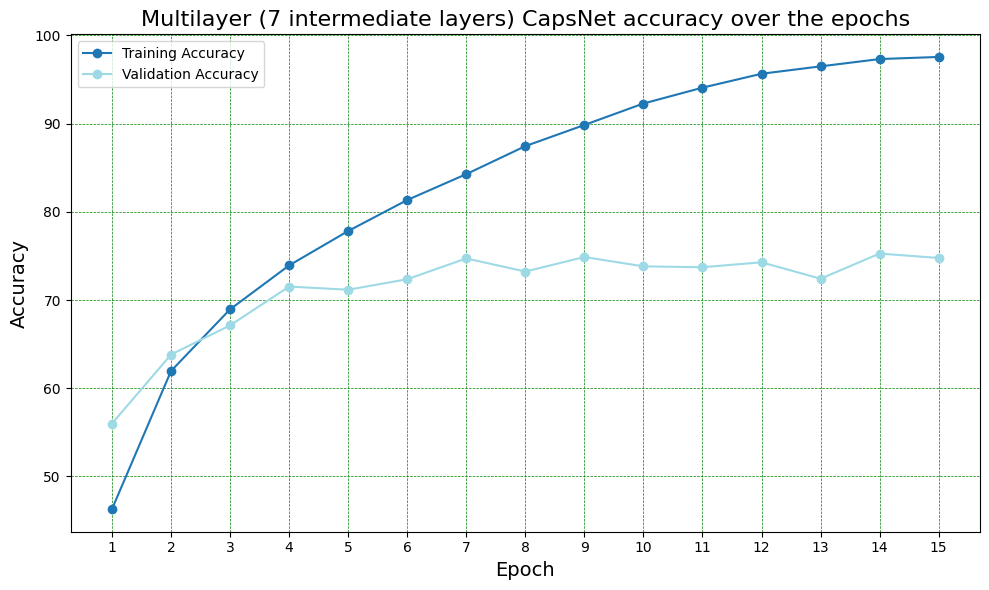

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (7 intermediate layers) CapsNet accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [8]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=8
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:05<00:00, 29377203.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter8_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 08:42:34 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7667, Top 1 Acc=9.38, Top 5 Acc=48.44
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7667, Top 1 Acc=9.38, Top 5 Acc=48.44
02/14 08:43:00 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5352, Top 1 Acc=22.09, Top 5 Acc=66.01
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5352, Top 1 Acc=22.09, Top 5 Acc=66.01
02/14 08:43:26 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4904, Top 1 Acc=28.15, Top 5 Acc=72.98
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4904, Top 1 Acc=28.15, Top 5 Acc=72.98
02/14 08:43:52 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4634, Top 1 Acc=32.25, Top 5 Acc=77.11


CPU times: user 1h 18min 13s, sys: 5min 5s, total: 1h 23min 18s
Wall time: 1h 23min 59s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter8_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter8_capsnet_cifar10_model.pt')

best_multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter8_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter8_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter8_capsnet_cifar10_model.name = 'best_multilayer_inter8_capsnet_cifar10_model'
best_multilayer_inter8_capsnet_cifar10_model = best_multilayer_inter8_capsnet_cifar10_model.to(device)
best_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter8_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter8_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:06:46 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=95.312
02/19 08:06:46 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=95.312
02/19 08:06:46 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=94.792
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=94.792
02/19 08:06:47 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=94.922
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/157

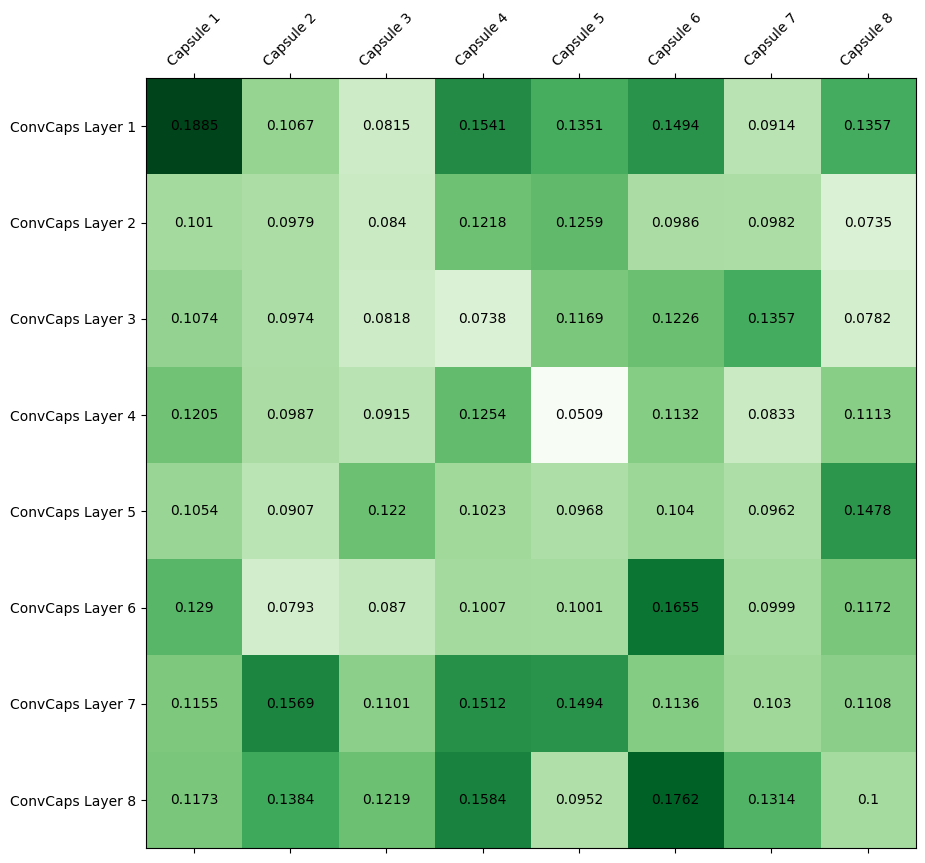

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter8_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

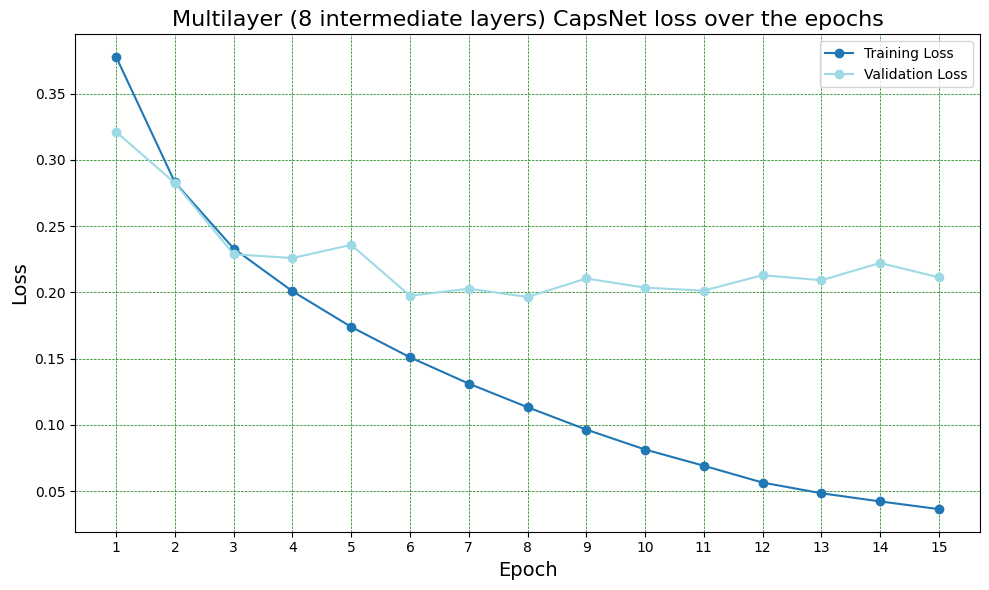

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (8 intermediate layers) CapsNet loss over the epochs')

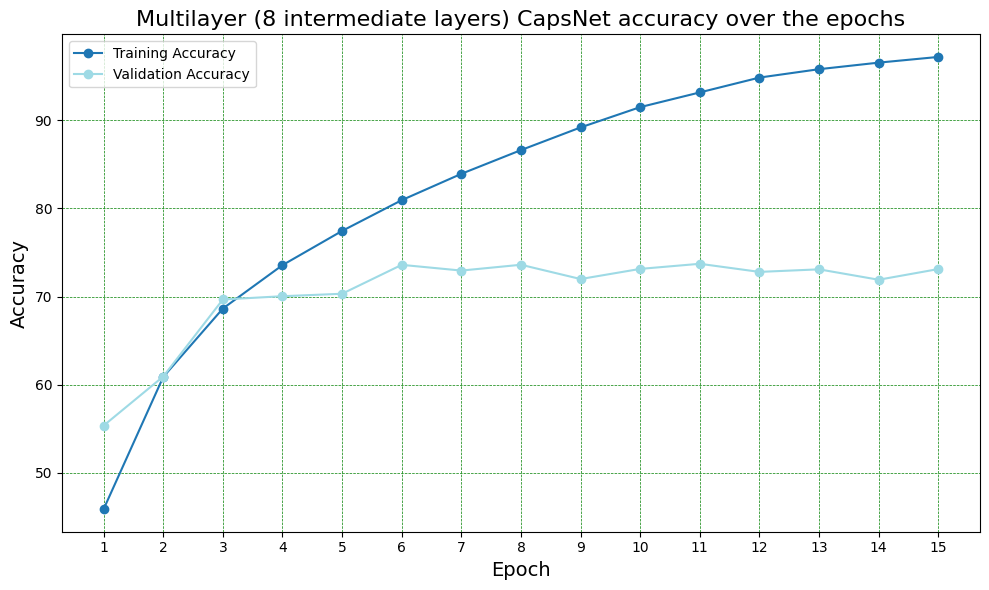

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (8 intermediate layers) CapsNet accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=9
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter9_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 07:10:29 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7852, Top 1 Acc=7.81, Top 5 Acc=56.25
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7852, Top 1 Acc=7.81, Top 5 Acc=56.25
02/14 07:10:59 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5399, Top 1 Acc=20.70, Top 5 Acc=66.85
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5399, Top 1 Acc=20.70, Top 5 Acc=66.85
02/14 07:11:27 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4933, Top 1 Acc=27.14, Top 5 Acc=73.66
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4933, Top 1 Acc=27.14, Top 5 Acc=73.66
02/14 07:11:57 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4673, Top 1 Acc=31.03, Top 5 Acc=77.17


CPU times: user 1h 25min 39s, sys: 5min 34s, total: 1h 31min 13s
Wall time: 1h 32min 1s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter9_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter9_capsnet_cifar10_model.pt')

best_multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter9_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter9_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter9_capsnet_cifar10_model.name = 'best_multilayer_inter9_capsnet_cifar10_model'
best_multilayer_inter9_capsnet_cifar10_model = best_multilayer_inter9_capsnet_cifar10_model.to(device)
best_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter9_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter9_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:09:38 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:09:39 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:09:39 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.396
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.396
02/19 08:09:39 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=73.047, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/157

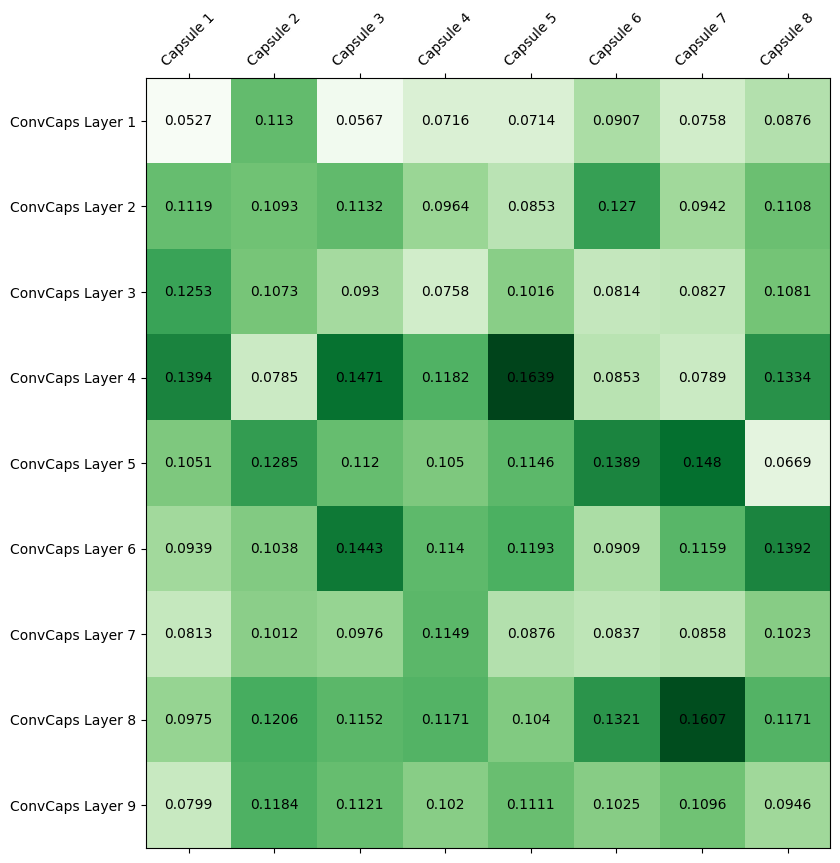

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter9_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

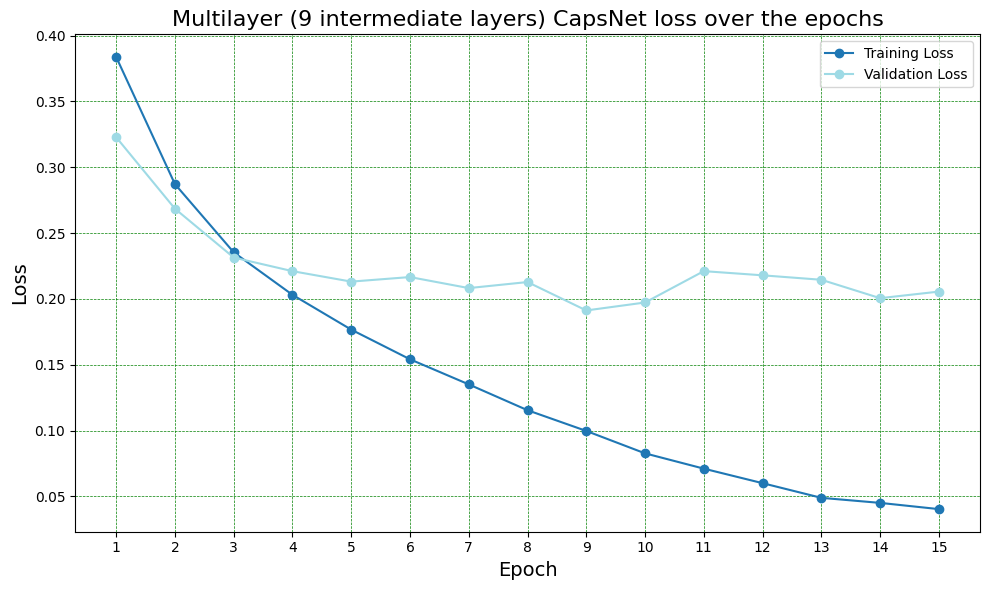

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (9 intermediate layers) CapsNet loss over the epochs')

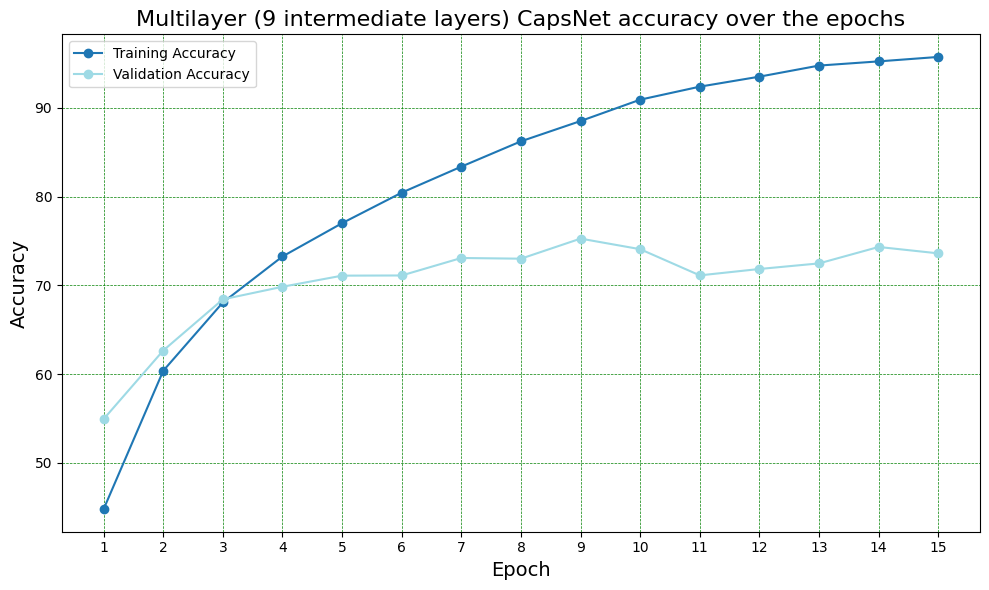

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (9 intermediate layers) CapsNet accuracy over the epochs')

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=10
prim_caps_channels=8
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:12<00:00, 13149784.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter10_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 05:29:14 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7868, Top 1 Acc=10.94, Top 5 Acc=51.56
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7868, Top 1 Acc=10.94, Top 5 Acc=51.56
02/14 05:29:46 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5456, Top 1 Acc=20.10, Top 5 Acc=63.89
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5456, Top 1 Acc=20.10, Top 5 Acc=63.89
02/14 05:30:19 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4980, Top 1 Acc=26.30, Top 5 Acc=71.78
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4980, Top 1 Acc=26.30, Top 5 Acc=71.78
02/14 05:30:50 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4720, Top 1 Acc=30.63, Top 5 A

CPU times: user 1h 34min 8s, sys: 6min 11s, total: 1h 40min 20s
Wall time: 1h 41min 14s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter10_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter10_capsnet_cifar10_model.pt')

best_multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter10_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter10_capsnet_cifar10_model.name = 'best_multilayer_inter10_capsnet_cifar10_model'
best_multilayer_inter10_capsnet_cifar10_model = best_multilayer_inter10_capsnet_cifar10_model.to(device)
best_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter10_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter10_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:11:22 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=93.750
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=93.750
02/19 08:11:22 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=92.969
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=92.969
02/19 08:11:23 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=93.750
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.646, Top 5 Acc=93.750
02/19 08:11:23 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=94.141
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iteratio

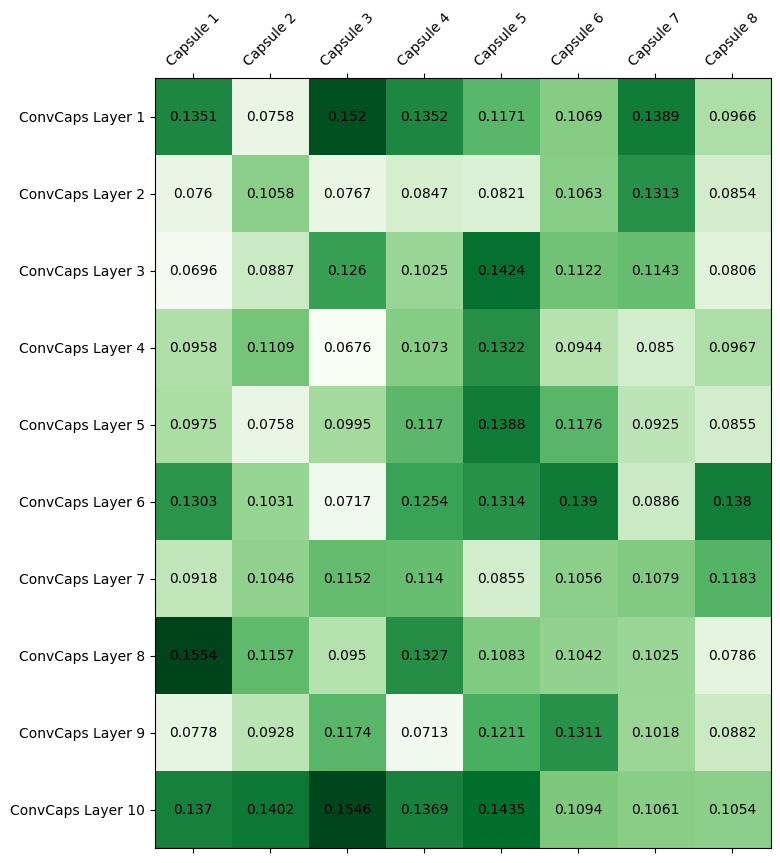

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter10_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 1

In [ ]:
trained_inter10_capsnet_model_epoch1 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch1_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch1['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch1'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
epoch1_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:24:36 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=50.000, Top 5 Acc=90.625
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=50.000, Top 5 Acc=90.625
03/02 07:24:36 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=55.469, Top 5 Acc=92.188
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=55.469, Top 5 Acc=92.188
03/02 07:24:37 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=54.688, Top 5 Acc=91.146
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=54.688, Top 5 Acc=91.146
03/02 07:24:37 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=4/157, Batch Size=64, Top 1 Acc=52.734, Top 5 Acc=89.453

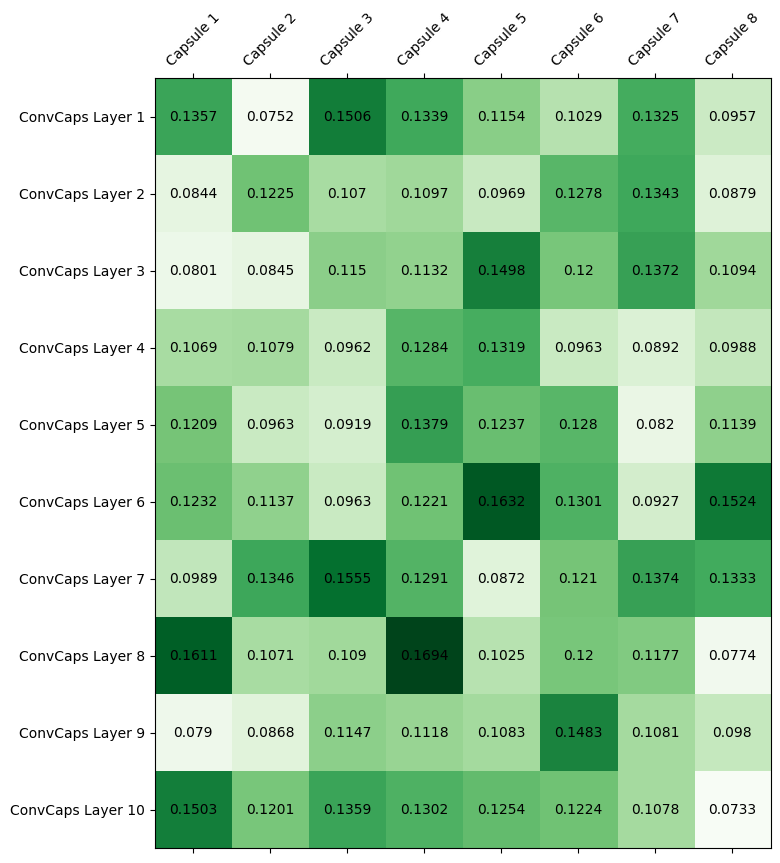

In [ ]:
utils.plot_caps_layers_activations(epoch1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 15

In [ ]:
trained_inter10_capsnet_model_epoch15 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch15['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch15'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
epoch15_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:25:12 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/157, Batch Size=64, Top 1 Acc=64.062, Top 5 Acc=92.188
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/157, Batch Size=64, Top 1 Acc=64.062, Top 5 Acc=92.188
03/02 07:25:13 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/157, Batch Size=64, Top 1 Acc=67.969, Top 5 Acc=92.969
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/157, Batch Size=64, Top 1 Acc=67.969, Top 5 Acc=92.969
03/02 07:25:13 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/157, Batch Size=64, Top 1 Acc=68.750, Top 5 Acc=92.708
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/157, Batch Size=64, Top 1 Acc=68.750, Top 5 Acc=92.708
03/02 07:25:13 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=4/157, Batch Size=64, Top 1 Acc=68.750, Top 5 Acc

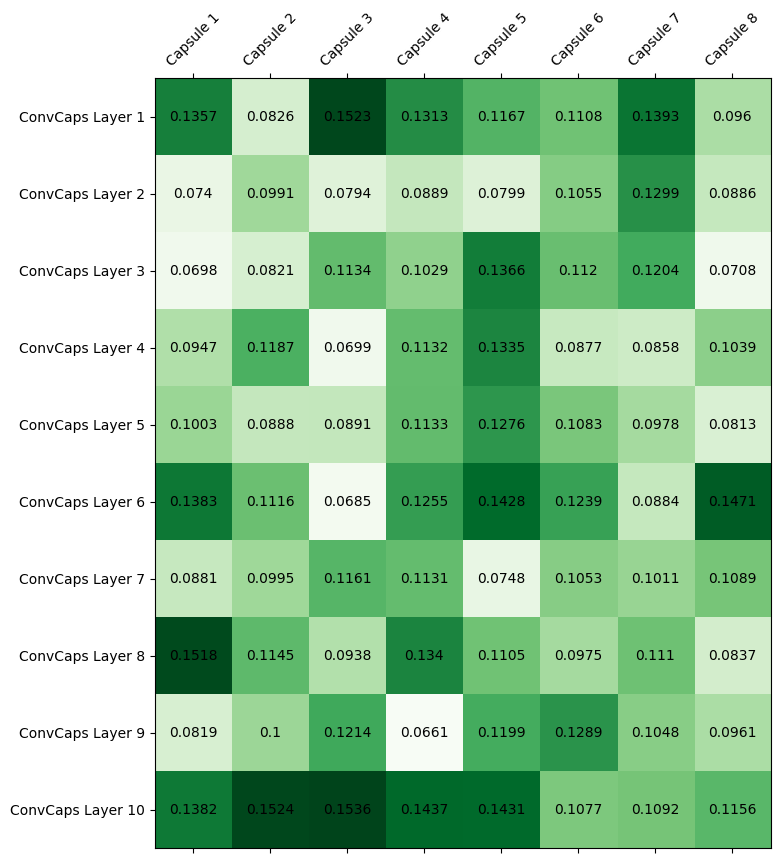

In [ ]:
utils.plot_caps_layers_activations(epoch15_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

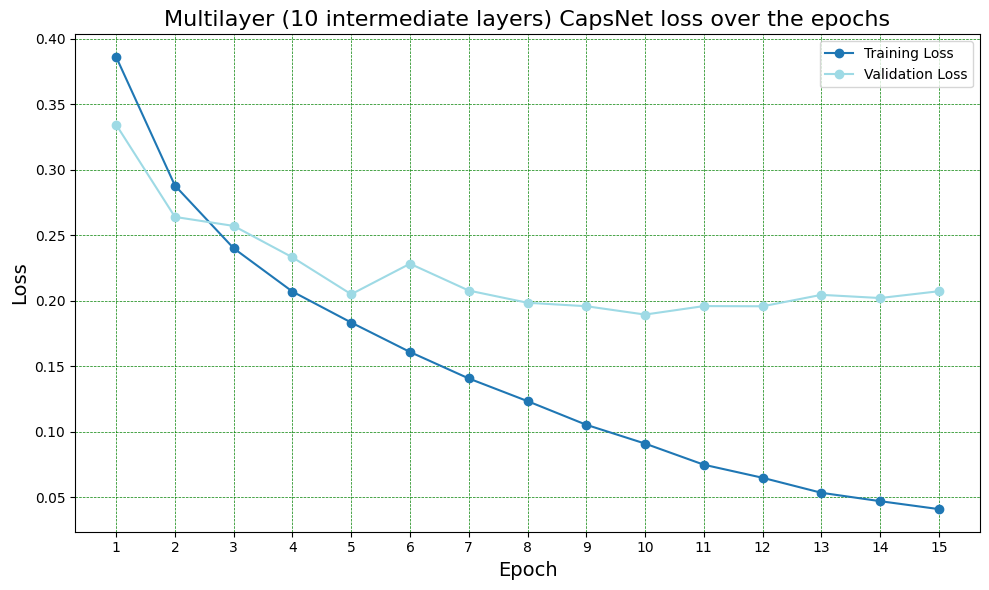

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (10 intermediate layers) CapsNet loss over the epochs')

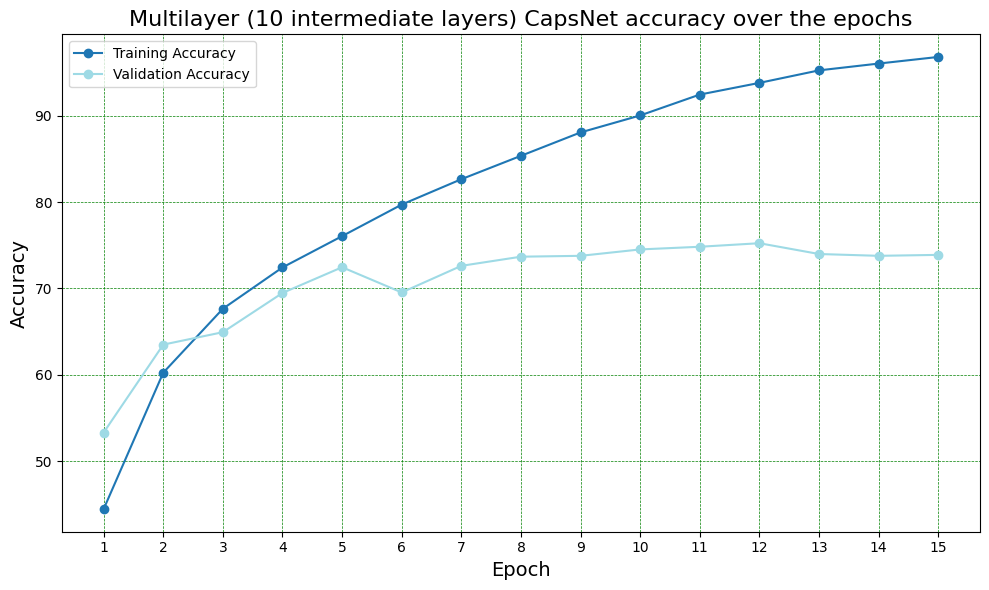

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (10 intermediate layers) CapsNet accuracy over the epochs')

## Plots for Base and All Multilayer CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

In [ ]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

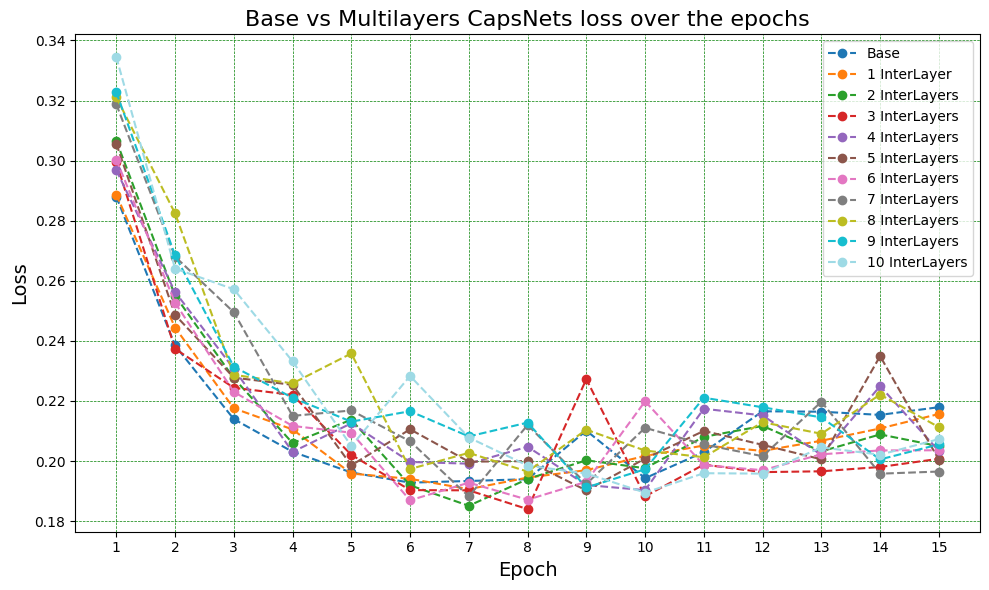

In [ ]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      'Base vs Multilayers CapsNets loss over the epochs', marker='o', line='--')

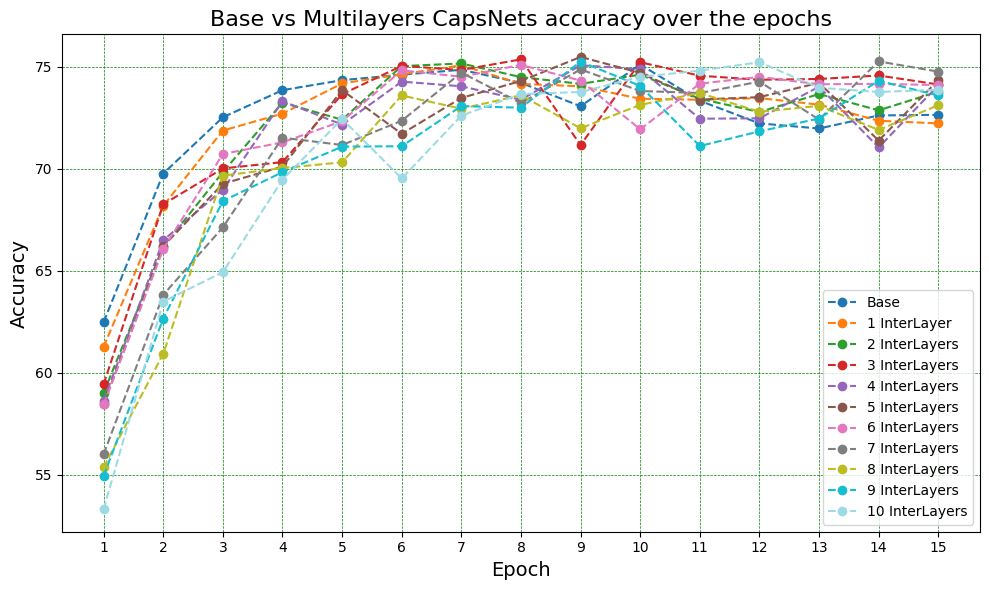

In [ ]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      'Base vs Multilayers CapsNets accuracy over the epochs', marker='o', line='--')

In [ ]:
print("disconnecting the runtime after 10 seconds")

time.sleep(10)

from google.colab import runtime
runtime.unassign()

disconnecting the runtime after 10 seconds
